In [2]:
import pickle
import pandas as pd
import requests
from bs4 import BeautifulSoup
import sys
import os
from collections import defaultdict
import re
import json
from collections import Counter
import dateutil
from dateutil import parser
from collections import defaultdict
from __future__ import division
import datetime
%pylab inline
from numpy import arange
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
def parseint(string):
    string = str(string)
    return int(''.join([x for x in string if x.isdigit()]))

In [4]:
with open('movie_info_revised.p' ,'r') as picklefile:
    data = pickle.load(picklefile)

In [5]:
def date_helper(date):
    try:
        date = parser.parse(date)
        return True
    except: 
        pass
    return False

In [23]:
history_keys_dic = defaultdict(dict)
for key in data.keys():
    if 'Sport' in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_keys_dic['count'][year]= history_keys_dic['count'].get(year, 0) + 1  
history_df = pd.DataFrame.from_dict(history_keys_dic)
start = pd.datetime(1980, 1, 1)
end = pd.datetime(2016, 1, 1)
x = pd.date_range(start, end, freq='A').year
history_df_years = history_df.reindex(x)
history_df = history_df_years.fillna(0)
history_df['cumulative mean']=pd.expanding_mean(history_df['count']).shift(+1)
history_df['difference from mean']=history_df['count']/history_df['cumulative mean']


In [24]:
history_keys_dic

defaultdict(<type 'dict'>, {'count': {1973: 1, 1975: 3, 1976: 4, 1977: 3, 1978: 6, 1979: 9, 1980: 2, 1982: 3, 1983: 1, 1984: 4, 1985: 3, 1986: 8, 1987: 2, 1988: 7, 1989: 3, 1990: 3, 1991: 4, 1992: 9, 1993: 1, 1994: 11, 1995: 1, 1996: 9, 1997: 1, 1998: 7, 1999: 3, 2000: 13, 2001: 5, 2002: 3, 2003: 5, 2004: 4, 2005: 15, 2006: 16, 2007: 11, 2008: 12, 2009: 6, 2010: 5, 2011: 8, 2012: 4, 2013: 1, 2015: 2}})

In [25]:
history_df

,count,cumulative mean,difference from mean
1980,2,NaN,NaN
1981,0,2.000000,0.000000
1982,3,1.000000,3.000000
1983,1,1.666667,0.600000
1984,4,1.500000,2.666667
1985,3,2.000000,1.500000
1986,8,2.166667,3.692308
1987,2,3.000000,0.666667
1988,7,2.875000,2.434783
1989,3,3.333333,0.900000


In [26]:
history_dic = defaultdict(dict)
for key in data.keys():
    if 'Sport' in data[key]['genre']:
        if date_helper(data[key]['date']):
            year = parser.parse(data[key]['date']).year
            history_dic[year][key]= defaultdict(dict)
            history_dic[year][key]['date']= data[key]['date']
            history_dic[year][key]['screens']= data[key]['screens']
            history_dic[year][key]['opening']= data[key]['opening']
                #space_dic['space'][year].append(key,)

In [27]:
history_dic

defaultdict(<type 'dict'>, {1973: {'The Last American Hero': defaultdict(<type 'dict'>, {'date': '27 July 1973', 'screens': 'n/a', 'opening': 'n/a'})}, 1975: {'Cornbread, Earl and Me': defaultdict(<type 'dict'>, {'date': '21 May 1975', 'screens': 'Error', 'opening': 'N/A'}), 'Rollerball': defaultdict(<type 'dict'>, {'date': '25 June 1975', 'screens': 'Error', 'opening': 'N/A'}), 'Hard Times': defaultdict(<type 'dict'>, {'date': '4 September 1975', 'screens': 'Error', 'opening': 'N/A'})}, 1976: {'Gus': defaultdict(<type 'dict'>, {'date': '7 July 1976', 'screens': 'n/a', 'opening': 'n/a'}), 'The Bingo Long Traveling All-Stars  Motor Kings': defaultdict(<type 'dict'>, {'date': '17 November 1976', 'screens': 'Error', 'opening': 'N/A'}), 'Rocky': defaultdict(<type 'dict'>, {'date': '3 December 1976', 'screens': 'Error', 'opening': 'N/A'}), 'The Bad News Bears': defaultdict(<type 'dict'>, {'date': '7 April 1976', 'screens': 'n/a', 'opening': 'n/a'})}, 1977: {'The Bad News Bears in Breaking T

In [28]:
def makedf(genre):
    frames = []
    years = []
    for year, movies in genre.items():
        years.append(year)
        frames.append(pd.DataFrame.from_dict(movies, orient='index'))
    genre = pd.concat(frames, keys=years)
    genre = genre[genre.screens != 'N/A']
    genre = genre[genre.screens != 'n/a']
    genre = genre[genre.screens != 'Error']
    genre = genre[genre.opening != 'N/A']
    genre = genre[genre.screens != '']
    genre = genre[genre.opening != '']
    genre = genre[genre.opening != 'n/a']
    genre = genre[genre.opening != 'Error']
    genre['opening'] = genre['opening'].map(lambda x: parseint(x))
    genre['screens'] = genre['screens'].map(lambda x: parseint(x))
    genre['date'] = genre['date'].map(lambda x: parser.parse(x))
    genre['normalized_opening']= genre['opening']/genre['screens']
    genre = genre[genre.normalized_opening < 20000]
    return genre

In [30]:
genre=makedf(history_dic)
pd.set_option('display.max_rows', 1000)
genre1 = genre[genre.screens > 50]
genre1 = genre1.reset_index()
genre1

,level_0,level_1,date,screens,opening,normalized_opening
0,1979,Rocky II,1979-06-15,780,6390537,8192.996154
1,1979,The Champ,1979-04-04,563,1972684,3503.879218
2,1980,Caddyshack,1980-07-25,656,3142689,4790.684451
3,1982,Rocky III,1982-05-28,939,12431486,13239.069223
4,1982,Six Pack,1982-07-16,504,1946418,3861.940476
5,1983,All the Right Moves,1983-10-21,229,1601167,6991.995633
6,1984,Hot Dog... The Movie,1984-01-13,1273,4506756,3540.263943
7,1984,Making the Grade,1984-05-18,1197,1760856,1471.057644
8,1984,Oxford Blues,1984-08-24,1075,2486418,2312.946977
9,1984,The Natural,1984-05-11,989,5088381,5144.975733


In [46]:
trend = genre1[70:124]
#trend = genre1[50:57]
#trend = genre1[66:74]
trend

,level_0,level_1,date,screens,opening,normalized_opening
70,2000,Ready to Rumble,2000-04-07,2007,7820836,3896.779273
71,2000,Remember the Titans,2000-09-29,1865,20905831,11209.560858
72,2000,The Legend of Bagger Vance,2000-11-03,2061,11516712,5587.924309
73,2000,The Replacements,2000-08-11,2754,11039214,4008.429194
74,2001,Ali,2001-12-25,2446,14710892,6014.264922
75,2001,Driven,2001-04-27,2905,12174504,4190.879174
76,2001,Hard Ball,2001-09-14,2137,9386342,4392.298549
77,2001,Out Cold,2001-11-21,2011,4531665,2253.438588
78,2002,Blue Crush,2002-08-16,3002,14169455,4720.004997
79,2003,Grind,2003-08-15,2253,2511403,1114.692854


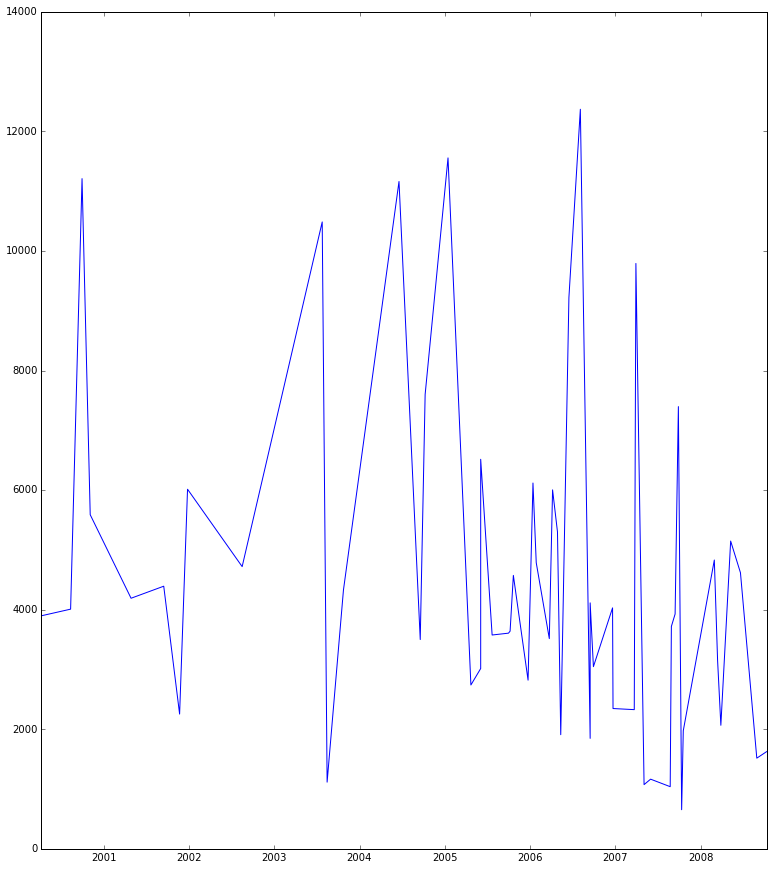

In [47]:
figure(figsize=(13,15))
trend = trend.sort(['date'])
plt.plot(trend['date'], trend['normalized_opening'])

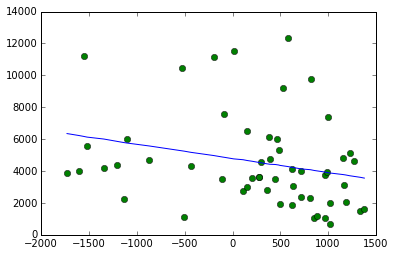

In [48]:
trend['time_delta']=trend['date'].apply(lambda x: str(x - parser.parse('2005-01-01')))
trend['time_delta_num'] = trend['time_delta'].str.replace(r'days[\s\S]+', '').apply(lambda x: int(x))

def sort_season(x):
    if x in [11, 12, 1]:
        return 4
    if x in [5, 6, 7, 8]:
        return 2
    if x in [9, 10,]:
        return 3
    if x in [2, 3, 4,]:
        return 1

trend['season']=trend['date'].apply(lambda x: sort_season(x.month))
from patsy import dmatrices
from patsy import dmatrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
#plot_data = trend
y, X = dmatrices('normalized_opening ~ time_delta_num + season', data = trend, return_type= 'dataframe')
model = sm.OLS(y, X)
fitted = model.fit()
plot(X['time_delta_num'], y, 'go')
plot(X['time_delta_num'], fitted.fittedvalues, 'b')

